# Condense AlphaFold prediction quality score

Having looked at the 100 worst scores for pLDDT and PAE, it is clear that using minimal pLDDT does not work very well to classify into bad prediction. Maximal PAE is even worse.

Here, we want to test a few additional metrics, namely mean pLDDT, median pLDDT, percentage of residues with pLDDT < 70, etc.

In [2]:
import glob
import gzip
import re

import pandas as pd
import numpy as np

from pqdm.threads import pqdm

In [2]:
def read_plddt_features_from_file(file: str):
    uni_prot_id = re.search(r"AF-([A-Z0-9]+)-", file).group(1)
    seq_len = 0
    pLDDT_scores = []
    with gzip.open(file, "rt") as handle:
        seen_res_i = 0
        for line in handle:
            # The sequence length is written in the DBREF line at the end
            if line.startswith('DBREF'):
                seq_len = int(line.rstrip().split()[-1])
            # The pLDDT is the last number in each ATOM line
            elif line.startswith('ATOM'):
                res_i = int(line[22:27])
                if res_i != seen_res_i:
                    seen_res_i = res_i
                    pLDDT = float(line[-20:-13])
                    pLDDT_scores.append(pLDDT)
    pLDDT_scores = np.asarray(pLDDT_scores)
    return uni_prot_id, np.round(np.mean(pLDDT_scores), decimals=4), np.round(np.median(pLDDT_scores), decimals=4), np.round(np.count_nonzero(pLDDT_scores < 70) / seq_len, decimals=4)

In [23]:
read_plddt_features_from_file("../data/alphafold/v2/UP000005640_9606_HUMAN_v2/AF-P04553-F1-model_v2.pdb.gz")

('P04553', 55.0116, 56.34, 1.0)

In [3]:
def read_features_from_file(file: str):
    uni_prot_id, mean_pLDDT, median_pLDDT, ratio_bad_pLDDT = read_plddt_features_from_file(file)
    return {
        "uniprot_id": uni_prot_id,
        "mean_plddt": mean_pLDDT,
        "median_plddt": median_pLDDT,
        "ratio_bad_plddt": ratio_bad_pLDDT,
    }


def read_features_for_proteome(folder: str):
    proteome = re.search(r"_([A-Z0-9]+)_v2", folder).group(1)
    df_proteome = pd.read_csv(f"../data/alphafold/v2/AA_scores/{proteome}.csv", index_col=0)
    if 'mean_plddt' in df_proteome:
        proteomes_with_mean_median.loc[len(proteomes_with_mean_median.index)] = [proteome]
        proteomes_with_mean_median.to_csv('../data/alphafold/v2/proteomes_with_mean_median.csv', header=False,
                                          index=False)
        print('Already filled with mean pLDDT')
        return
    files = glob.glob(f"{folder}/*.pdb.gz")
    seq_infos = pqdm(files, read_features_from_file, n_jobs=10, desc=f'Files in {folder}')
    df_mean_scores = pd.DataFrame(seq_infos).drop_duplicates()
    df_combined = df_proteome.merge(df_mean_scores, on="uniprot_id", how="left")
    df_combined.to_csv(f"../data/alphafold/v2/AA_scores/{proteome}.csv")

In [5]:
folders = glob.glob("../data/alphafold/v2/*_v2")
proteomes_with_mean_median = pd.read_csv("../data/alphafold/v2/proteomes_with_mean_median.csv", header=None)
proteomes_with_mean_median_list = proteomes_with_mean_median.squeeze('columns').to_list()
folders_to_extend = list(filter(lambda file: re.search(r"_([A-Z0-9]+)_v2", file).group(1) not in proteomes_with_mean_median_list, folders))
pqdm(folders_to_extend, read_features_for_proteome, n_jobs=3, desc='Folders')

SUBMITTING | Folders:   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING | Folders:   0%|          | 0/1 [00:00<?, ?it/s]

Already filled with mean pLDDT


COLLECTING | Folders:   0%|          | 0/1 [00:00<?, ?it/s]

[None]

In [3]:
dfs = []
for proteome_file in glob.glob('../data/alphafold/v2/AA_scores/*.csv'):
    proteome = re.search(r"/([A-Z0-9]+).csv", proteome_file).group(1)
    proteome_df = pd.read_csv(proteome_file, index_col=0)
    proteome_df['proteome'] = proteome
    dfs.append(proteome_df)
df = pd.concat(dfs)

In [4]:
df.describe()

,seq_len,domain_count,max_pae,min_plddt,mean_plddt,median_plddt,ratio_bad_plddt,iupred_auc
count,545555.000000,545555.00000,542051.000000,545555.000000,545555.000000,545555.000000,545555.000000,522125.000000
mean,458.873356,1.11808,30.845778,33.727809,75.312362,79.094267,0.354822,125.969805
std,880.781186,12.27124,1.455963,11.363737,14.949144,18.772187,0.291004,147.224706
min,16.000000,0.00000,6.000000,1.390000,23.077300,22.170000,0.000000,0.000000
25%,186.000000,0.00000,30.900000,25.620000,64.928350,64.540000,0.112200,38.063900
50%,333.000000,0.00000,31.300000,31.180000,77.976200,87.315000,0.272000,80.049100
75%,538.000000,1.00000,31.400000,38.590000,87.562600,93.995000,0.552100,156.520200
max,32200.000000,285.00000,31.700000,97.030000,98.724100,98.860000,1.000000,2730.699900


In [8]:
# Get 100 worst for each metric
df.nlargest(n=100, columns='ratio_bad_plddt')[['uniprot_id', 'ratio_bad_plddt']].to_csv(
    '../data/alphafold/100/100_highest_ratio_bad_plddt.csv', index=None)
df.nsmallest(n=100, columns='mean_plddt')[['uniprot_id', 'mean_plddt']].to_csv(
    '../data/alphafold/100/100_smallest_mean_plddt.csv', index=None)
df.nsmallest(n=100, columns='median_plddt')[['uniprot_id', 'median_plddt']].to_csv(
    '../data/alphafold/100/100_smallest_median_plddt.csv', index=None)

In [5]:
import matplotlib.pyplot as plt

In [26]:
df_short = df[df['seq_len'] < 3000]

In [27]:
length_buckets_indices = range(0, df_short['seq_len'].max(), 250)
length_buckets = [df_short[df_short['seq_len'].between(i, i + 249)] for i in length_buckets_indices]
labels = [f'{i}-{i+249}' for i in length_buckets_indices]

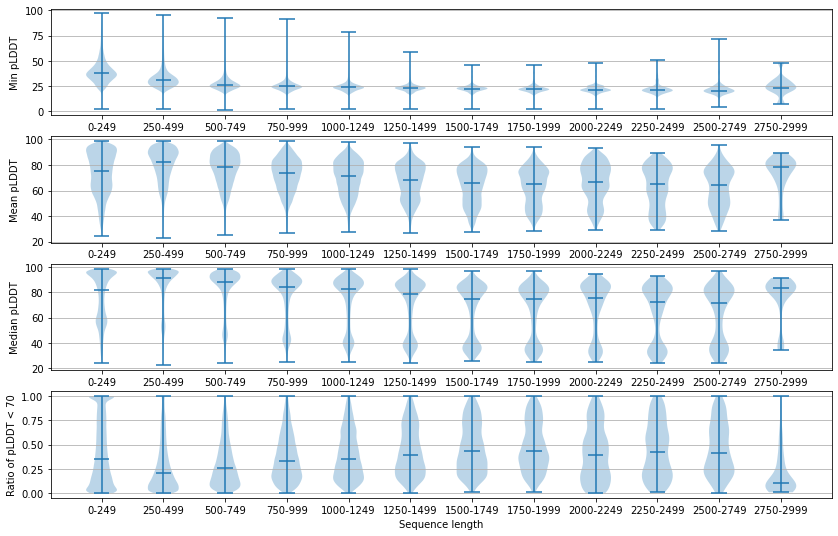

In [28]:
%matplotlib inline
fig, [ax1, ax2, ax3, ax4] = plt.subplots(nrows=4, figsize=(14, 9))


def plot_violins_by_sequence_length(ax, field: str, ylabel: str):
    ax.violinplot(dataset=[bucket[field].values for bucket in length_buckets], showmedians=True)
    ax.yaxis.grid(True)
    ax.set_xlabel('Sequence length')
    ax.set_ylabel(ylabel)
    ax.set_xticks(np.arange(1, len(labels) + 1), labels=labels)


plot_violins_by_sequence_length(ax1, 'min_plddt', 'Min pLDDT')
plot_violins_by_sequence_length(ax2, 'mean_plddt', 'Mean pLDDT')
plot_violins_by_sequence_length(ax3, 'median_plddt', 'Median pLDDT')
plot_violins_by_sequence_length(ax4, 'ratio_bad_plddt', 'Ratio of pLDDT < 70')

plt.show()